# OpenCV Overlay: Filter2D

This notebook illustrates the kinds of things you can do with accelerated openCV cores built as a PYNQ overlay. The overlay consists of a 2D filter and this example notebook does the following.
1. Sets up HDMI drivers
2. Run software-only filter2D on HDMI input and output results to HDMI output
3. Sets up widget for controlling different the filter kernel
4. Run hardware accelerated filter2D function

NOTE: Rough FPS values are computed for each stage

## Program overlay

Here we program the overlay and load the pynq python libraries for a memory manager and the accelerator drivers.
NOTE: All overlay and python libraries should be loaded prior to assigning the HDMI input/outputs. This is necessary right now to ensure correct functionality but will be enhanced in future releases. For now, please copy this block as is when using it in your own designs.

In [1]:
from pynq.lib.video import *
from pynq.overlays.bare_hdmi import BareHDMIOverlay
base = BareHDMIOverlay("/home/xilinx/pynq/overlays/computer_vision/"
                       "xv2Filter2DDilate.bit")
from pynq import Xlnk
mem_manager = Xlnk()
import pynq.overlays.computer_vision.xv2Filter2DDilate as xv2

hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

## Setup and configure HDMI drivers 

~15 seconds to initialize HDMI input/output

In [2]:
hdmi_in.configure(PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

## Setup up HDMI input/output parameters 

These parameters are referenced in later function calls

In [3]:
mymode = hdmi_in.mode
print("My mode: "+str(mymode))

height = hdmi_in.mode.height
width = hdmi_in.mode.width
bpp = hdmi_in.mode.bits_per_pixel

My mode: VideoMode: width=1920 height=1080 bpp=8


## Run SW Filter2D 

~10 seconds

In [4]:
import numpy as np
import cv2

#laplacian filter, high-pass  
kernelF = np.array([[0.0, 1.0, 0],[1.0, -4, 1.0],[0, 1.0, 0.0]],np.float32) 

numframes = 20

start = time.time()
for _ in range(numframes):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    cv2.filter2D(inframe, -1, kernelF, dst=outframe)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  3.5829672070783163


Show input frame in notebook

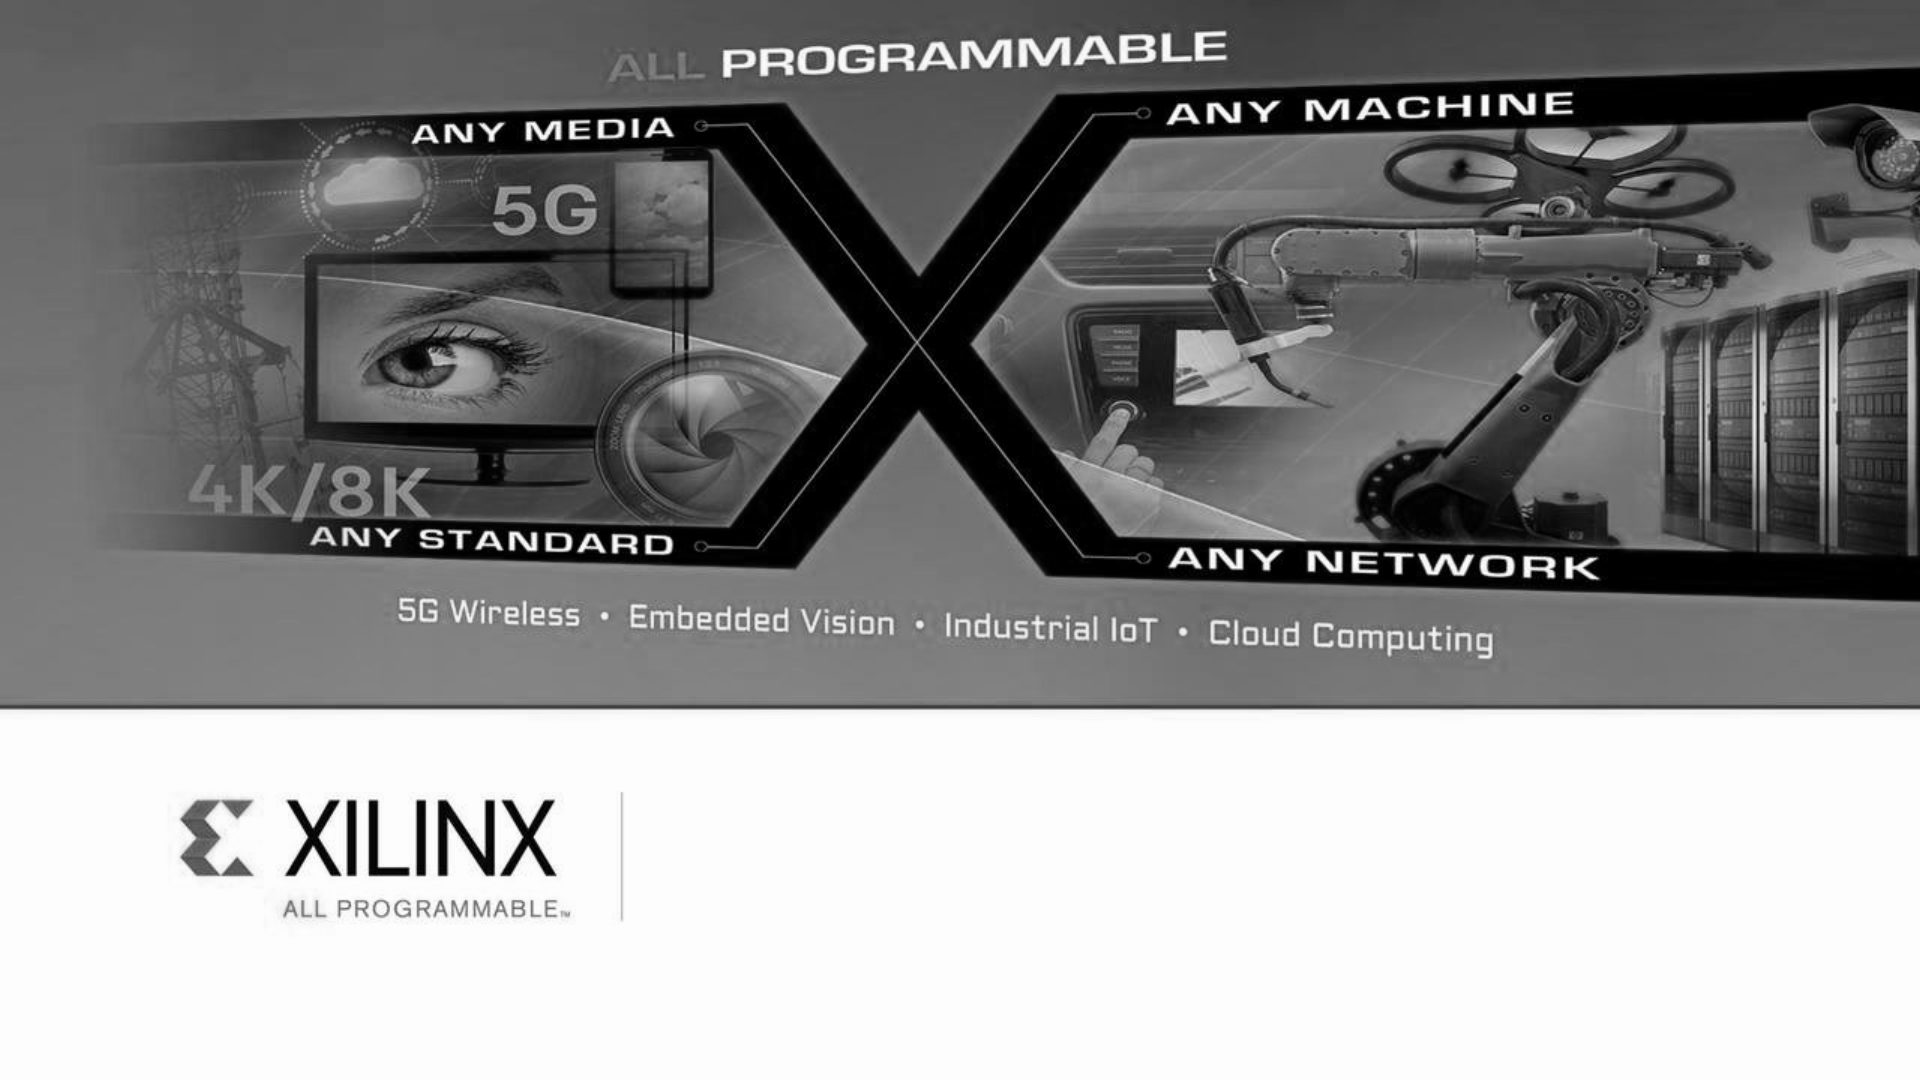

In [5]:
import PIL.Image

image = PIL.Image.fromarray(inframe)
image

Show output frame after filter2D in notebook.

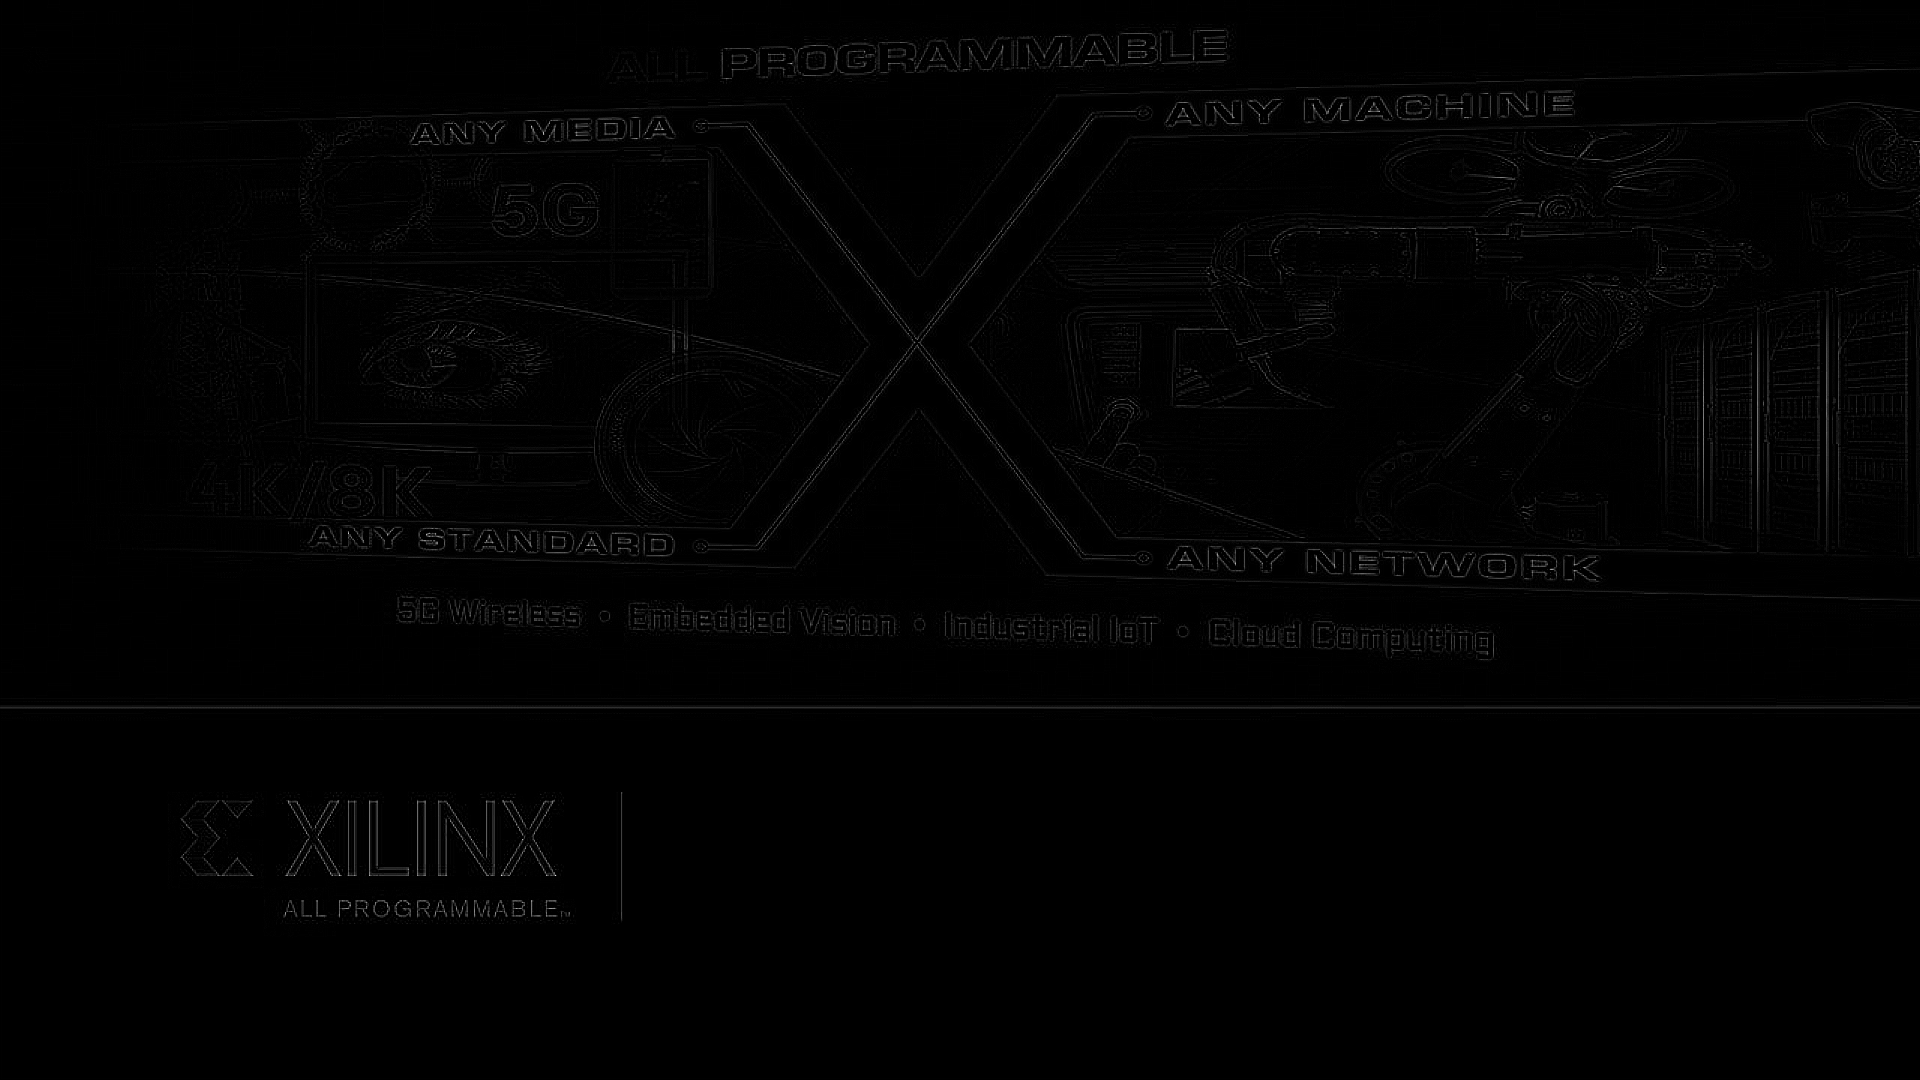

In [6]:
import PIL.Image

image = PIL.Image.fromarray(outframe)
image

## Setup control widgets

Here, we define some kernel configurations that will be used to change the functionality of the 2D filter on the fly. A pulldown menu will appear below this cell to be used to change the filter2D kernel used subsequent cells.

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider, FloatSlider
import ipywidgets as widgets

#laplacian filter, high-pass
kernel_g = np.array([[0.0, 1.0, 0],[1.0, -4, 1.0],[0, 1.0, 0.0]],np.float32)   

def setKernelAndFilter3x3(kernelName):
    global kernel_g

    kernel_g = {
        'laplacian high-pass': np.array([[0.0,1.0,0.0],[1.0,-4.0,1.0],
                                         [0.0,1.0,0.0]],np.float32),
        'gaussian high-pass': np.array([[-0.0625,-0.125,-0.0625],
                                        [-0.125,0.75,-0.125],
                                        [-0.0625,-0.125,-0.0625]],np.float32),
        'average blur':  np.ones((3,3),np.float32)/9.0,
        'gaussian blur': np.array([[0.0625,0.125,0.0625],
                                   [0.125,0.25,0.125],
                                   [0.0625,0.125,0.0625]],np.float32),
        'Sobel Ver': np.array([[1.0,0.0,-1.0],[2.0,0.0,-2.0],
                               [1.0,0.0,-1.0]],np.float32),
        'Sobel Hor': np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],
                               [-1.0,-2.0,-1.0]],np.float32)
    }.get(kernelName, np.ones((3,3),np.float32)/9.0)

interact(setKernelAndFilter3x3, kernelName
         = ['laplacian high-pass','gaussian high-pass','average blur',
            'gaussian blur','Sobel Hor','Sobel Ver']);

interactive(children=(Dropdown(description='kernelName', options=('laplacian high-pass', 'gaussian high-pass', 'average blur', 'gaussian blur', 'Sobel Hor', 'Sobel Ver'), value='laplacian high-pass'), Output()), _dom_classes=('widget-interact',))

## Run HW filter2D

~20 seconds

Running this kernel with a clock of 142 MHz gives a performance of about ~60 fps.

NOTE: In order to allow kernel redefintion on the fly, subsequent function call are run as threads. This means you will not know if the cell is finished based on the cell status on the left. Be sure to wait until FPS information is reported before running other cells. Also note that if you use the widget to change the kernel, the FPS info will show up underneath the widget cell rather than the function block cell.

In [8]:
import numpy as np

def loop_hw2_app():
    global kernel_g
      
    numframes = 600

    start=time.time()
    for _ in range(numframes):
        inframe = hdmi_in.readframe()
        outframe = hdmi_out.newframe()
        xv2.filter2D(inframe, -1, kernel_g, outframe, (-1,-1), 0.0, 
                     borderType=cv2.BORDER_CONSTANT)
        inframe.freebuffer()
        hdmi_out.writeframe(outframe)
    end=time.time()
    print("Frames per second:  " + str(numframes / (end - start)))

from threading import Thread

t = Thread(target=loop_hw2_app, )
t.start()

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/python3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/python3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-8-ad24d6c1d1ae>", line 15, in loop_hw2_app
    hdmi_out.writeframe(outframe)
  File "/opt/python3.6/lib/python3.6/site-packages/pynq/lib/video.py", line 1292, in writeframe
    self._vdma.writechannel.writeframe(frame)
  File "/opt/python3.6/lib/python3.6/site-packages/pynq/lib/video.py", line 630, in writeframe
    loop = asyncio.get_event_loop()
  File "/opt/python3.6/lib/python3.6/asyncio/events.py", line 671, in get_event_loop
    return get_event_loop_policy().get_event_loop()
  File "/opt/python3.6/lib/python3.6/asyncio/events.py", line 583, in get_event_loop
    % threading.current_thread().name)
RuntimeError: There is no current event loop in thread 'Thread-5'.



Show output frame after filter2D in notebook.

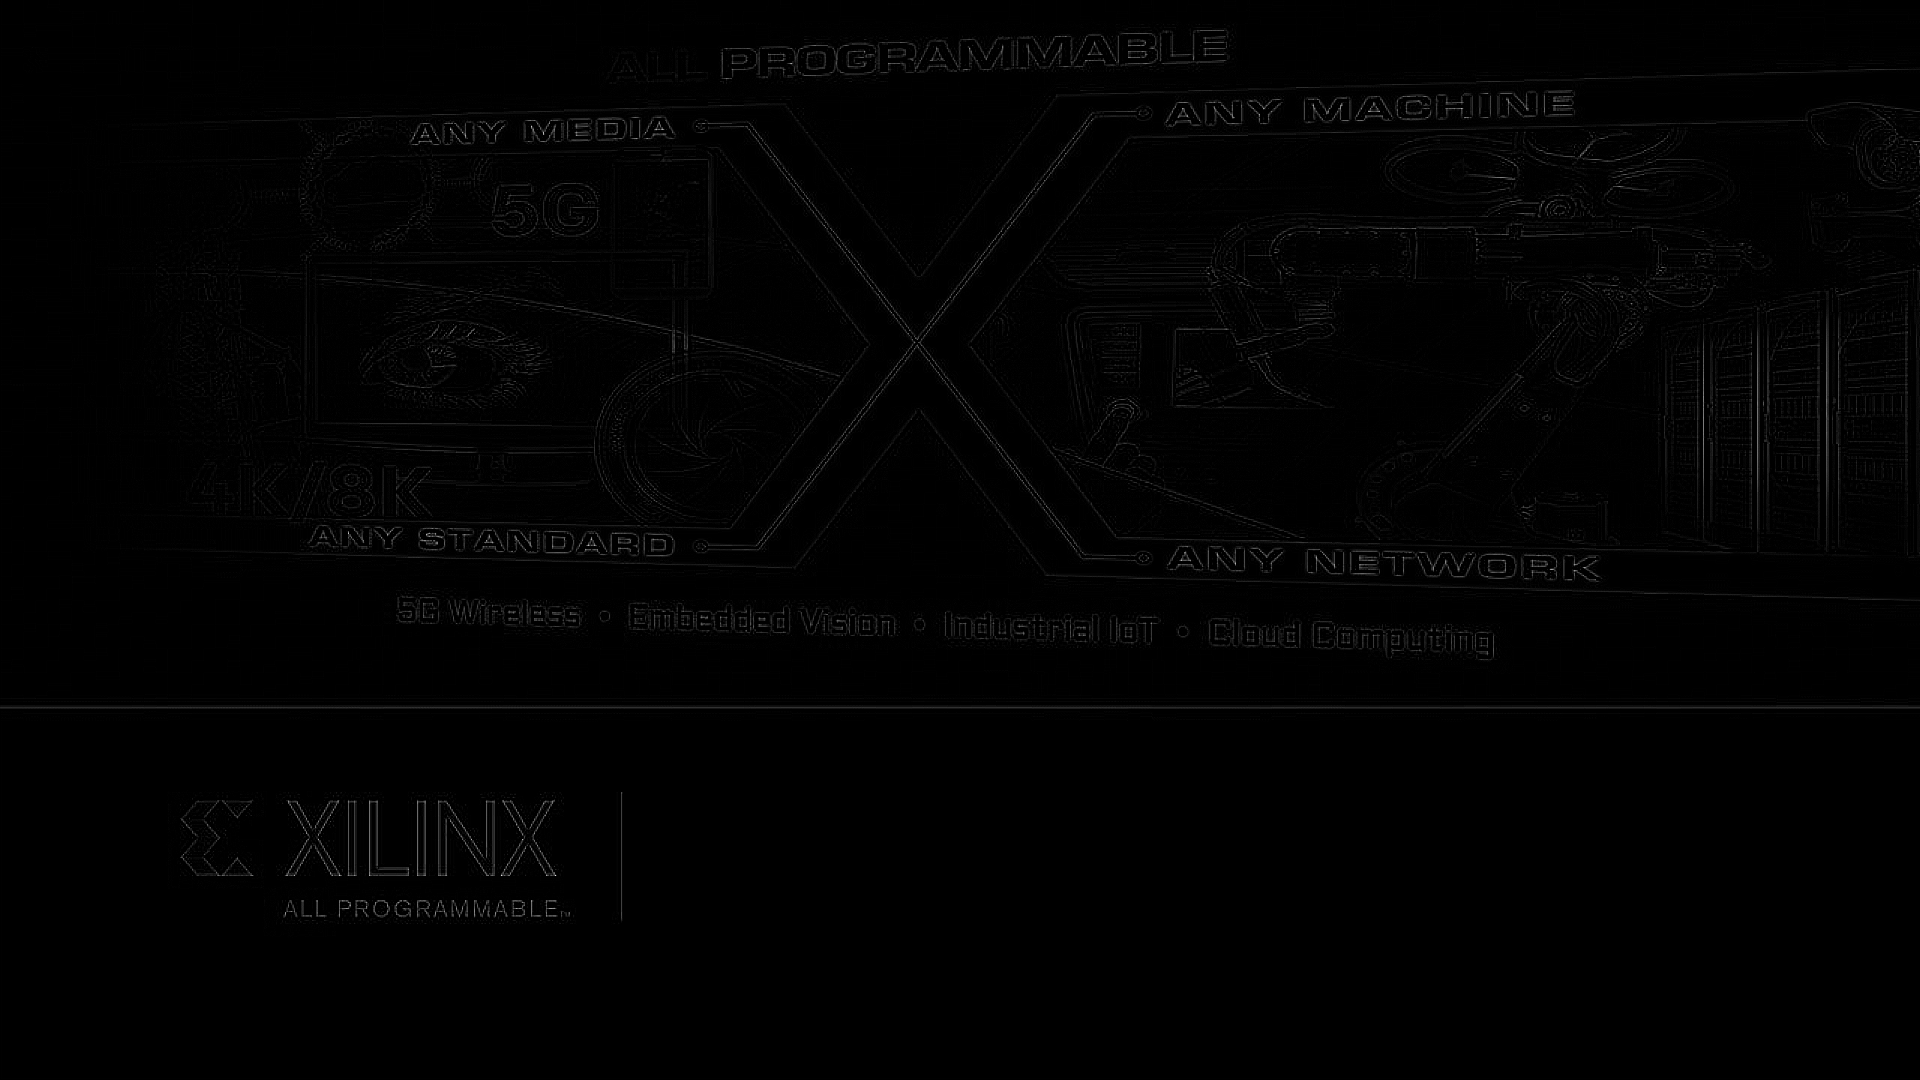

In [9]:
import PIL.Image

image = PIL.Image.fromarray(outframe)
image

## Clean up hdmi drivers

NOTE: This is needed to reset the HDMI drivers in a clean state. If this is not run, subsequent executions of this notebook may show visual artifacts on the HDMI out (usually a shifted output image)

In [10]:
hdmi_out.close()
hdmi_in.close()